<a href="https://colab.research.google.com/github/Michle99/BreastCancerDiagnosis/blob/main/BreastCancerDatasetClassificationDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install imutils

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!ls /content/drive/MyDrive/datasets/
!ls /content/drive/MyDrive/datasets/idc/
!ls /content/drive/MyDrive/datasets/orig/

idc  orig
testing  training  validation
10253  10254  8863  8864


In [ ]:
#set the data set folder
import os
#original input data set path
ORIGINAL_INPUT_DATASET = "/content/drive/MyDrive/datasets/orig/"
#master folder to contain the train test valid data 
BASE_PATH = "/content/drive/MyDrive/datasets/idc/"
#derive the training testing and validation directories
TRAIN_PATH = os.path.sep.join([BASE_PATH , 'training'])
VAL_PATH = os.path.sep.join([BASE_PATH , 'validation'])
TEST_PATH = os.path.sep.join([BASE_PATH , "testing"])
#Train test split
TRAIN_SPLIT = 0.8
#validation split
VAL_SPLIT = 0.1

In [ ]:
!ls /content/drive/MyDrive/datasets/idc/

testing  training  validation


In [ ]:
from imutils import paths
import shutil
import random
import os

#grab the paths to the input images in the base folder
imgPaths = list(paths.list_images(ORIGINAL_INPUT_DATASET))
#define a random seed to shuffle
random.seed(42)
random.shuffle(imgPaths)
print(len(imgPaths))

2006


In [ ]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

Class Label  1


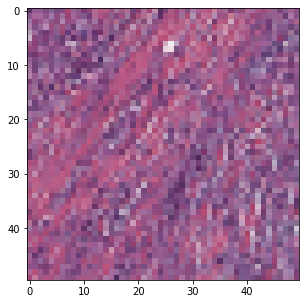

In [ ]:
#do some visualization
test_img_path = imgPaths[5]
class_label = test_img_path.split(os.path.sep)[-2]
print("Class Label " ,class_label)
image = Image.open(test_img_path)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()

In [ ]:
#take 80% of the data from the folder
imgPaths = imgPaths[:int(len(imgPaths)*0.7)]
#define the split index for train  test
split_idx = int(len(imgPaths)*TRAIN_SPLIT)
trainPaths= imgPaths[:split_idx]
testPaths = imgPaths[split_idx:]

#define the train val split
val_split = int(len(trainPaths)*VAL_SPLIT)
valPaths = trainPaths[:val_split]
trainPaths = trainPaths[val_split:]

#define the datasets
datasets=[
    ('training',trainPaths , TRAIN_PATH),
    ('validation' , valPaths , VAL_PATH),
    ('testing' , testPaths , TEST_PATH)
]

for (dtype , imgPaths , baseoutput) in datasets:
    print("Building the Dataset for ",dtype)
    #if the base output is not exists then create a folder
    if not os.path.exists(baseoutput):
        print("Create a directory for the dataset ", baseoutput)
        os.makedirs(baseoutput)
    
    for imgPath in imgPaths :
        #define the class and the file name
        filename = imgPath.split(os.path.sep)[-1]
        label = filename[-5:-4]
        #build the path to the label directory for 1 and 0
        labelPath = os.path.sep.join([baseoutput,label])
        
        if not os.path.exists(labelPath):
            print("Create the directory for the label {}".format(labelPath))
            os.makedirs(labelPath)        
        p = os.path.sep.join([labelPath,filename])
     
        shutil.copy2(imgPath , p)

Building the Dataset for  training
Building the Dataset for  validation
Building the Dataset for  testing


In [ ]:
!ls /content/drive/MyDrive/datasets/idc/

testing  training  validation


In [ ]:
from torchvision import datasets
import torch
from torchvision import transforms
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 

transform_train = transforms.Compose([
    transforms.Pad(64, padding_mode='reflect'),
    transforms.RandomRotation((0,10)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor() ,
    transforms.Normalize([0.5,0.5,0.5] , [0.5,0.5,0.5])
])
transform_test = transforms.Compose([
    transforms.Pad(64, padding_mode='reflect'),
    transforms.ToTensor() ,
    transforms.Normalize([0.5,0.5,0.5] , [0.5,0.5,0.5])
])
transform_valid = transforms.Compose([
    transforms.Pad(64, padding_mode='reflect'),
    transforms.ToTensor() ,
    transforms.Normalize([0.5,0.5,0.5] , [0.5,0.5,0.5])
])


dataset_train = datasets.ImageFolder('/content/drive/MyDrive/datasets/idc/training' ,transform=transform_train)                                                                         
dataset_test = datasets.ImageFolder("/content/drive/MyDrive/datasets/idc/testing",transform=transform_test)   
dataset_valid = datasets.ImageFolder("/content/drive/MyDrive/datasets/idc/validation",transform=transform_valid)

# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64 , sampler = sampler, num_workers=0, pin_memory=True)   
test_loader = torch.utils.data.DataLoader(dataset_test , batch_size=32 , pin_memory=True)
valid_loader = torch.utils.data.DataLoader(dataset_valid , batch_size=32 , pin_memory=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D , Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

In [ ]:
class CancerNet :
    @staticmethod
    def build(width , height , depth , classes):
        model= Sequential()
        inputShape = (height , width , depth)
        channel_dim = -1
        
        if K.image_data_format()=="channels_first":
            inputShape = (depth , height , width)
            channel_dim =1
            
        #using the seprable convs getting higher computation but the kernels not getting much higher accuracy    
        model.add(Conv2D(32 , (3,3) , padding='same' , input_shape=inputShape , 
                         kernel_regularizer = regularizers.l1_l2(l1=1e-2 , l2=1e-3)))
        
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(64 , (3,3) , padding='same' , 
                                 kernel_regularizer = regularizers.l1_l2(l1=1e-3)))
        
        
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(128 , (3,3) , padding='same' , 
                                 kernel_regularizer = regularizers.l1_l2(l1=1e-3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256 , (3,3) , padding='same' , 
                                 kernel_regularizer = regularizers.l1_l2(l1=1e-3)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(512 , (3,3) , padding='same' , 
                                 kernel_regularizer = regularizers.l1_l2(l1=1e-3)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(Conv2D(1024 , (3,3) , padding='same' , 
                                 kernel_regularizer = regularizers.l1_l2(l1=1e-3)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=channel_dim))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25)) 
        
        #add the dense layers
        model.add(Flatten())
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

In [ ]:
#implement the training scipt
import matplotlib
matplotlib.use("Agg")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils  import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import keras

NUM_EPOCHS = 40
INIT_LR = 1e-2
BS = 32

trainPaths = list(paths.list_images(TRAIN_PATH))
totalTrain = len(trainPaths)
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

trainLabels = [int(p.split(os.path.sep)[-2])  for p in trainPaths]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()

#for all the classes calculate the weight
for i in range(0,len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]

In [ ]:
import tensorflow as tf
with tf.device("gpu:0"):
   print("tf.keras code in this scope will run on GPU")

tf.keras code in this scope will run on GPU


In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.05,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
#define the training generators
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH ,
    class_mode = 'categorical',
    target_size=(48,48) ,
    color_mode = 'rgb',
    shuffle=True ,
    batch_size=BS
)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)
# initialize the testing generator
testGen = valAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 1011 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Found 281 images belonging to 2 classes.


In [ ]:
model = CancerNet.build(width=48 , height=48 , depth=3 ,classes=2)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.SGD(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy', optimizer=opt , metrics=['accuracy'])

H = model.fit(
    x = trainGen , 
    steps_per_epoch = totalTrain // BS ,
    validation_data = valGen ,
    validation_steps = totalVal//BS ,
    class_weight = classWeight ,
    epochs = 10 )



Epoch 1/10
31/31 [==============================] - 121s 4s/step - loss: 89.4535 - accuracy: 0.7899 - val_loss: 87.1542 - val_accuracy: 0.1979
Epoch 2/10
31/31 [==============================] - 115s 4s/step - loss: 86.1907 - accuracy: 0.8839 - val_loss: 84.2512 - val_accuracy: 0.1979
Epoch 3/10
31/31 [==============================] - 115s 4s/step - loss: 83.2711 - accuracy: 0.8586 - val_loss: 81.4141 - val_accuracy: 0.1979
Epoch 4/10
31/31 [==============================] - 114s 4s/step - loss: 80.3368 - accuracy: 0.8898 - val_loss: 78.5573 - val_accuracy: 0.8021
Epoch 5/10
31/31 [==============================] - 113s 4s/step - loss: 77.5438 - accuracy: 0.8643 - val_loss: 75.7183 - val_accuracy: 0.8021
Epoch 6/10
31/31 [==============================] - 115s 4s/step - loss: 74.7175 - accuracy: 0.8816 - val_loss: 73.1293 - val_accuracy: 0.8125
Epoch 7/10
31/31 [==============================] - 116s 4s/step - loss: 72.0956 - accuracy: 0.8652 - val_loss: 70.7883 - val_accuracy: 0.4688

In [ ]:
print("Model Evaluation ")
testGen.reset()
predIdx = model.predict(x = testGen , steps=(totalTest//BS)+1)

predIdx = np.argmax(predIdx , axis=1)
print(classification_report(testGen.classes , predIdx , target_names=testGen.class_indices.keys()))

Model Evaluation 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       177
           1       0.82      0.82      0.82       104

    accuracy                           0.86       281
   macro avg       0.85      0.85      0.85       281
weighted avg       0.86      0.86      0.86       281



In [ ]:
cm = confusion_matrix(testGen.classes , predIdx)
print(cm)

[[158  19]
 [ 19  85]]
